# Cell Nuclei Separation - Watershed

In [1]:
import cv2
import numpy as np
from torch.utils.data import Dataset
from pathlib import Path
import torch
import matplotlib.pyplot as plt

In [4]:
class WatershedPreprocessor:
    def __init__(self, size=(256, 256)):
        self.size = size

    def __call__(self, image, instance_mask):
        image = cv2.resize(image, self.size)

        instance_mask = cv2.resize(
            instance_mask, 
            self.size, 
            interpolation=cv2.INTER_NEAREST
        )

        binary_mask = (instance_mask > 0).astype(np.uint8)

        dist_map = cv2.distanceTransform(binary_mask, cv2.DIST_L2, 5)

        if dist_map.max() > 0:
            dist_map = dist_map / dist_map.max()

        _, sure_fg = cv2.threshold(dist_map, 0.25, 1.0, cv2.THRESH_BINARY)

        sure_fg = sure_fg.astype(np.uint8)

        num_markers, markers = cv2.connectedComponents(sure_fg)

        return image, binary_mask, instance_mask, dist_map, markers

In [5]:
class NucleiWatershedDataset(Dataset):
    def __init__(self, data_path, preprocessor=None):
        self.data_path = Path(data_path)
        self.preprocessor = preprocessor
        self.image_ids = sorted(
            [d.name for d in self.data_path.iterdir() if d.is_dir()]
        )

        print(f"Found {len(self.image_ids)} samples")

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]

        img_path = list(
            (self.data_path / image_id / 'images').glob('*')
        )[0]

        image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

        mask_dir = self.data_path / image_id / 'masks'
        masks = list(mask_dir.glob('*.png'))

        instance_mask = np.zeros_like(image, dtype=np.int32)

        for i, m_path in enumerate(masks):
            m = cv2.imread(str(m_path), cv2.IMREAD_GRAYSCALE)
            instance_mask[m > 0] = i + 1  # assigning unique label

        if self.preprocessor:
            image, binary_mask, instance_mask, dist_map, markers = \
                self.preprocessor(image, instance_mask)

        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) / 255.0
        binary_mask = torch.tensor(binary_mask, dtype=torch.float32)
        instance_mask = torch.tensor(instance_mask, dtype=torch.long)
        dist_map = torch.tensor(dist_map, dtype=torch.float32)
        markers = torch.tensor(markers, dtype=torch.long)

        return {
            "image": image,
            "binary_mask": binary_mask,
            "instance_mask": instance_mask,
            "distance_map": dist_map,
            "markers": markers,
            "id": image_id
        }

In [6]:
preprocessor = WatershedPreprocessor(size=(256, 256))

train_dataset = NucleiWatershedDataset(
    'data/',
    preprocessor=preprocessor
)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

sample = next(iter(train_loader))
print(sample["image"].shape)

Found 671 samples
torch.Size([4, 1, 256, 256])


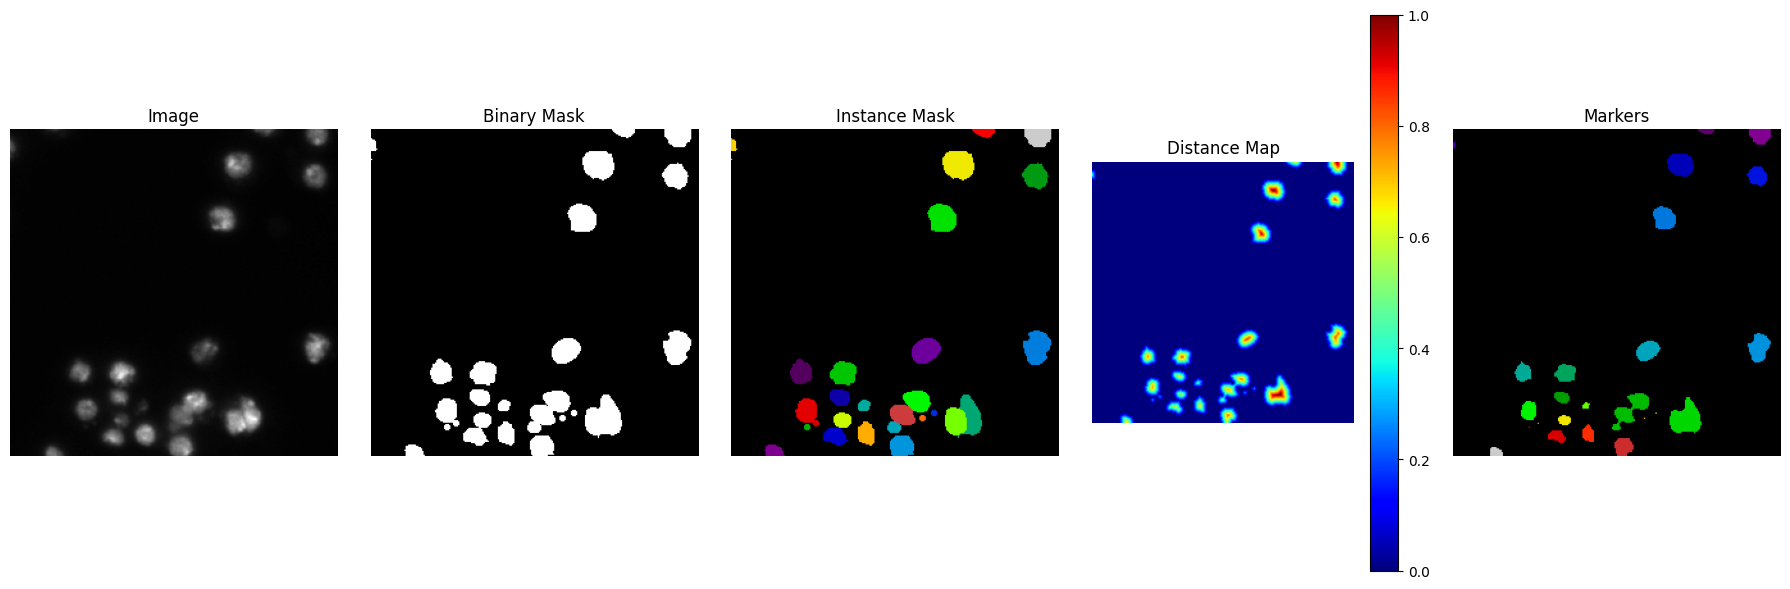

In [7]:
def visualize_sample(dataset, index=0):
    sample = dataset[index]

    image = sample["image"].squeeze().numpy()
    binary_mask = sample["binary_mask"].numpy()
    instance_mask = sample["instance_mask"].numpy()
    distance_map = sample["distance_map"].numpy()
    markers = sample["markers"].numpy()

    plt.figure(figsize=(18, 6))

    # Original Image
    plt.subplot(1, 5, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Image")
    plt.axis("off")

    # Binary Mask
    plt.subplot(1, 5, 2)
    plt.imshow(binary_mask, cmap='gray')
    plt.title("Binary Mask")
    plt.axis("off")

    # Instance Mask (colored)
    plt.subplot(1, 5, 3)
    plt.imshow(instance_mask, cmap='nipy_spectral')
    plt.title("Instance Mask")
    plt.axis("off")

    # Distance Transform
    plt.subplot(1, 5, 4)
    plt.imshow(distance_map, cmap='jet')
    plt.title("Distance Map")
    plt.colorbar()
    plt.axis("off")

    # Markers
    plt.subplot(1, 5, 5)
    plt.imshow(markers, cmap='nipy_spectral')
    plt.title("Markers")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
    
visualize_sample(train_dataset, index=0)

In [8]:
def watershed_without_markers(image, binary_mask):
    """
    Naive watershed using binary mask directly
    """

    img = (image * 255).astype(np.uint8)
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Connected components on binary mask
    num_labels, markers = cv2.connectedComponents(binary_mask.astype(np.uint8))

    markers = markers.astype(np.int32)

    cv2.watershed(img_color, markers)

    return markers

In [10]:
def watershed_with_markers(image, markers):
    """
    Marker controlled watershed
    """

    img = (image * 255).astype(np.uint8)
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    markers = markers.astype(np.int32)

    cv2.watershed(img_color, markers)

    return markers

In [11]:
def visualize_watershed_comparison(dataset, index=0):
    sample = dataset[index]

    image = sample["image"].squeeze().numpy()
    binary_mask = sample["binary_mask"].numpy()
    instance_mask = sample["instance_mask"].numpy()
    markers = sample["markers"].numpy()

    ws_no_markers = watershed_without_markers(image, binary_mask)
    ws_with_markers = watershed_with_markers(image, markers)

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(instance_mask, cmap='nipy_spectral')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(ws_no_markers, cmap='nipy_spectral')
    plt.title("Without Markers")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(ws_with_markers, cmap='nipy_spectral')
    plt.title("With Markers")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

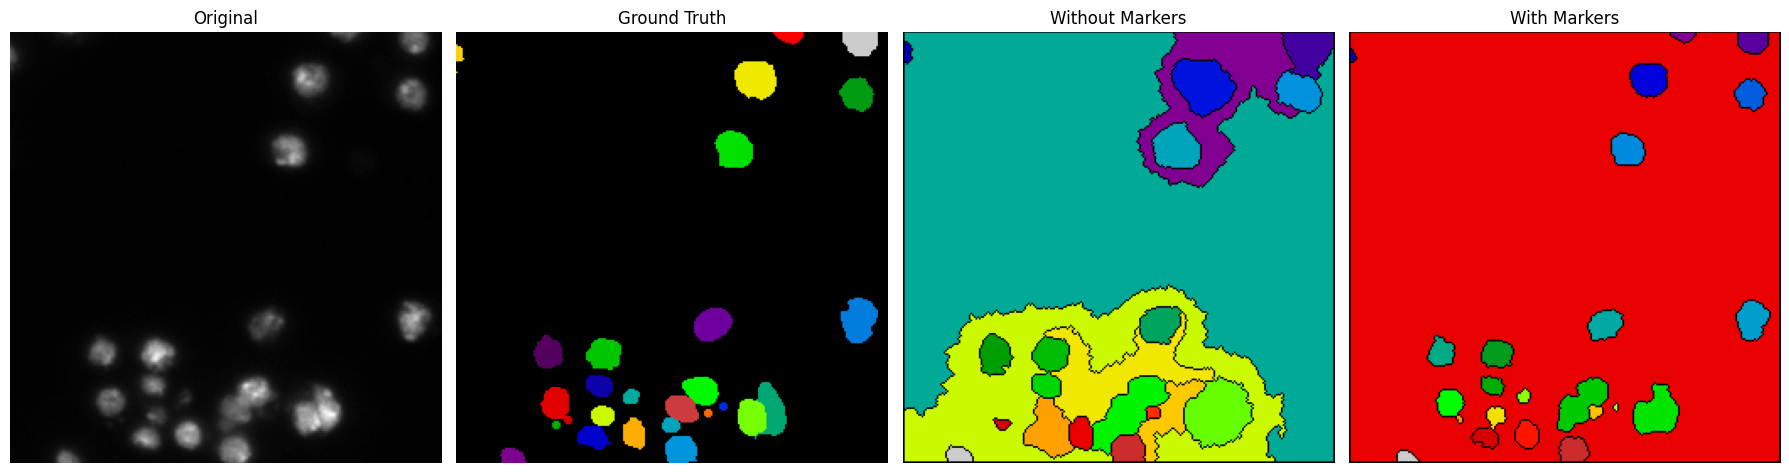

In [12]:
visualize_watershed_comparison(train_dataset, 0)

In [13]:
def count_instances(mask):
    labels = np.unique(mask)
    labels = labels[labels > 0]
    return len(labels)


def evaluate_sample(dataset, index=0):
    sample = dataset[index]

    image = sample["image"].squeeze().numpy()
    binary_mask = sample["binary_mask"].numpy()
    instance_mask = sample["instance_mask"].numpy()
    markers = sample["markers"].numpy()

    ws_no_markers = watershed_without_markers(image, binary_mask)
    ws_with_markers = watershed_with_markers(image, markers)

    gt_count = count_instances(instance_mask)
    no_marker_count = count_instances(ws_no_markers)
    marker_count = count_instances(ws_with_markers)

    print("Ground Truth nuclei:", gt_count)
    print("Without markers nuclei:", no_marker_count)
    print("With markers nuclei:", marker_count)

    print("\nOver-segmentation (No markers):", no_marker_count - gt_count)
    print("Over-segmentation (With markers):", marker_count - gt_count)

In [14]:
evaluate_sample(train_dataset, 0)

Ground Truth nuclei: 27
Without markers nuclei: 22
With markers nuclei: 24

Over-segmentation (No markers): -5
Over-segmentation (With markers): -3


In [15]:
from tqdm import tqdm

def evaluate_dataset(dataset, max_samples=100):
    total_gt = 0
    total_no_marker = 0
    total_marker = 0

    n_samples = min(len(dataset), max_samples)

    print(f"Evaluating on {n_samples} samples...\n")

    for i in tqdm(range(n_samples)):
        sample = dataset[i]

        image = sample["image"].squeeze().numpy()
        binary_mask = sample["binary_mask"].numpy()
        instance_mask = sample["instance_mask"].numpy()
        markers = sample["markers"].numpy()

        ws_no_markers = watershed_without_markers(image, binary_mask)
        ws_with_markers = watershed_with_markers(image, markers)

        total_gt += count_instances(instance_mask)
        total_no_marker += count_instances(ws_no_markers)
        total_marker += count_instances(ws_with_markers)

    print("\n===== RESULTS =====")
    print("Total Ground Truth:", total_gt)
    print("Total Without Markers:", total_no_marker)
    print("Total With Markers:", total_marker)

    print("\nAvg Over-segmentation (No markers):",
          (total_no_marker - total_gt) / n_samples)

    print("Avg Over-segmentation (With markers):",
          (total_marker - total_gt) / n_samples)

In [16]:
evaluate_dataset(train_dataset, max_samples=100)

Evaluating on 100 samples...



100%|██████████| 100/100 [00:06<00:00, 15.02it/s]


===== RESULTS =====
Total Ground Truth: 4854
Total Without Markers: 3757
Total With Markers: 3915

Avg Over-segmentation (No markers): -10.97
Avg Over-segmentation (With markers): -9.39
